## Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging

import sklearn as sklear

import core.dataframe_modeler as cdataf
import core.signal_processing as csigna
import helpers.dbg as dbg
import helpers.env as henv
import helpers.printing as hprint
import vendors2.kibot.data.load.futures_forward_contracts as vkdlfu
import vendors2.kibot.data.load.s3_data_loader as vkdls3
import vendors2.kibot.metadata.load.kibot_metadata as vkmlki

/commodity_research/amp/core/dataframe_modeler.py:20: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
dbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

# Packages
         python: 3.7.9
       gluonnlp: 0.10.0
        gluonts: 0.6.3
         joblib: 0.17.0
          mxnet: 1.7.0
          numpy: 1.19.4
         pandas: 1.1.4
        pyarrow: 2.0.0
          scipy: 1.5.3
        seaborn: 0.11.0
        sklearn: 0.23.2
    statsmodels: 0.12.1
# Last commits:
  * e9bb7e1e paul     Extend notebook                                                   (61 seconds ago) Sat Jan 30 02:09:47 2021  (HEAD -> gallery_kibot2)
  * a523021e paul     Checkpoint notebook                                               (   4 hours ago) Fri Jan 29 22:03:18 2021           
  *   4551c063 Paul     Merge pull request #995 from alphamatic/AmpTask940_GetExpiryFunctionKibot_05 (  31 hours ago) Thu Jan 28 19:17:18 2021           
  |\  


## Map contracts to start and end dates

In [3]:
lfc_hc = vkmlki.KibotHardcodedContractLifetimeComputer(365, 7)

lfc_hc.compute_lifetime("CLJ17")

ContractLifetime(start_date=Timestamp('2016-03-22 00:00:00'), end_date=Timestamp('2017-03-15 00:00:00'))

In [4]:
lfc_ta = vkmlki.KibotTradingActivityContractLifetimeComputer()

lfc_ta.compute_lifetime("CLJ17")

ContractLifetime(start_date=Timestamp('2011-11-18 00:00:00'), end_date=Timestamp('2017-03-21 00:00:00'))

In [5]:
symbols = ["ES", "CL"]
file = "../contracts.csv"


fcl = vkmlki.FuturesContractLifetimes(file, lfc_hc)

In [6]:
fcl.save(["CL"])

Found credentials in shared credentials file: ~/.aws/credentials


In [7]:
cl_data = fcl.load(["CL"])

In [8]:
cl_data["CL"].head()

,symbol,contract,start_date,end_date
0,CL,CLX09,2008-10-21,2009-10-14
1,CL,CLZ09,2008-11-20,2009-11-13
2,CL,CLF10,2008-12-22,2009-12-15
3,CL,CLG10,2009-01-20,2010-01-13
4,CL,CLH10,2009-02-22,2010-02-15


## Create continuous contracts

In [9]:
fcem = vkmlki.FuturesContractExpiryMapper(cl_data)

In [10]:
fcem.get_nth_contract("CL", "2010-01-01", 1)

'CLG10'

In [11]:
srs = fcem.get_nth_contracts("CL", "2010-01-10", "2010-01-20", freq="B", n=1)

In [12]:
srs

2010-01-11    CLG10
2010-01-12    CLG10
2010-01-13    CLG10
2010-01-14    CLH10
2010-01-15    CLH10
2010-01-18    CLH10
2010-01-19    CLH10
2010-01-20    CLH10
Freq: B, Name: CL1, dtype: object

In [13]:
kdl = vkdls3.S3KibotDataLoader()

In [14]:
ffc_obj = vkdlfu.FuturesForwardContracts(kdl)

In [15]:
ffc_obj._replace_contracts_with_data(srs)

,open,high,low,close,vol
2010-01-11,82.88,83.95,81.96,82.52,296304.0
2010-01-12,82.07,82.34,79.91,80.79,333866.0
2010-01-13,80.06,80.67,78.37,79.65,401627.0
2010-01-14,79.97,80.75,79.32,79.88,197449.0
2010-01-15,79.73,79.75,78.09,78.37,190088.0
2010-01-18,NaN,NaN,NaN,NaN,NaN
2010-01-19,78.21,79.47,77.06,79.32,351108.0
2010-01-20,79.17,79.36,77.13,77.74,303758.0


## Combine front and back contracts

In [16]:
cl_df = fcem.get_contracts(
    ["CL1", "CL2", "CL3", "CL4"], "2010-01-01", "2015-12-31", freq="B"
)

In [17]:
cl_df.head()

,CL1,CL2,CL3,CL4
2010-01-01,CLG10,CLH10,CLJ10,CLK10
2010-01-04,CLG10,CLH10,CLJ10,CLK10
2010-01-05,CLG10,CLH10,CLJ10,CLK10
2010-01-06,CLG10,CLH10,CLJ10,CLK10
2010-01-07,CLG10,CLH10,CLJ10,CLK10


In [18]:
price_df = ffc_obj.replace_contracts_with_data(cl_df, "close")

<AxesSubplot:>

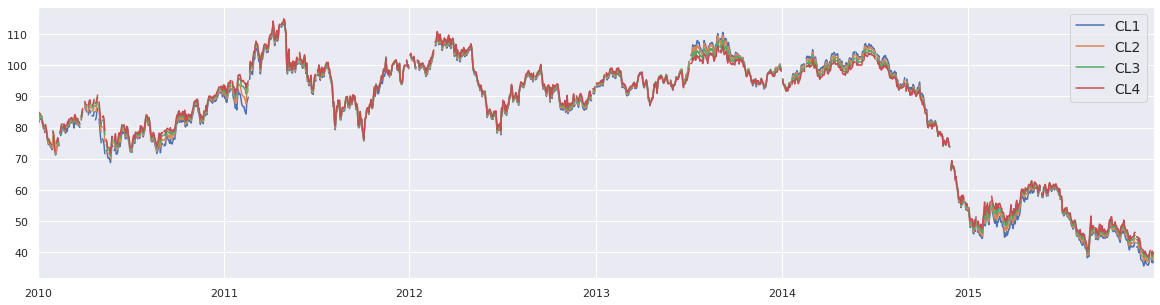

In [19]:
price_df.plot()

In [20]:
dfm = (
    cdataf.DataFrameModeler(df=price_df, oos_start="2013-01-01")
    .compute_ret_0(method="predict")
    .apply_column_transformer(
        transformer_func=csigna.compute_rolling_zscore,
        transformer_kwargs={
            "tau": 10,
            "min_periods": 20,
        },
        col_mode="replace_all",
        method="predict",
    )
)

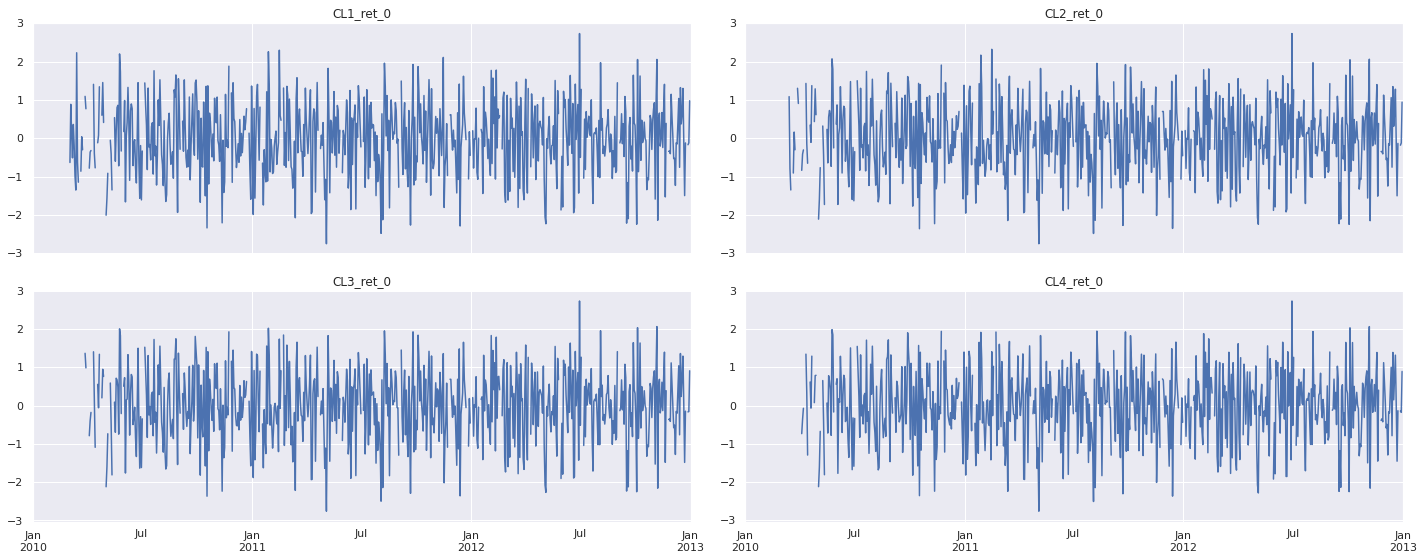

In [21]:
dfm.plot_time_series()

Plotting all 4 components
num_components=4


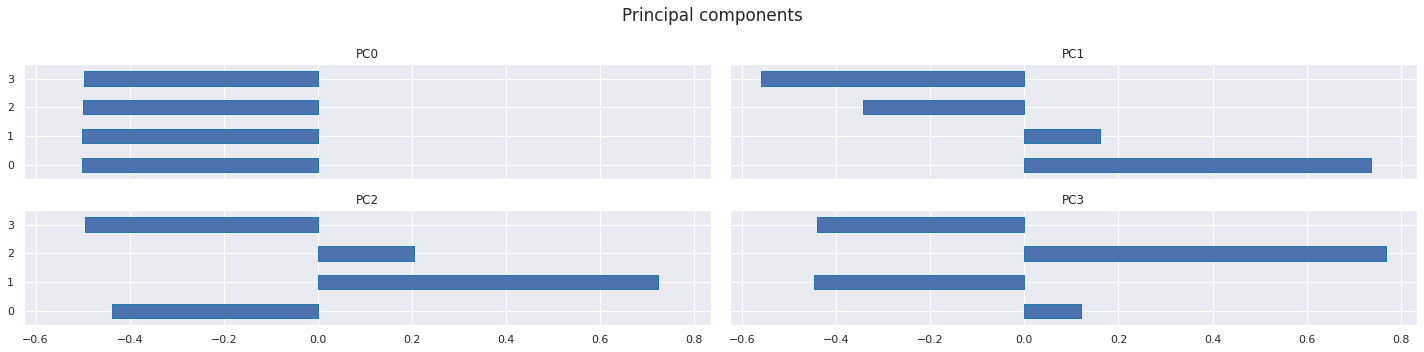

In [22]:
dfm.plot_pca_components()

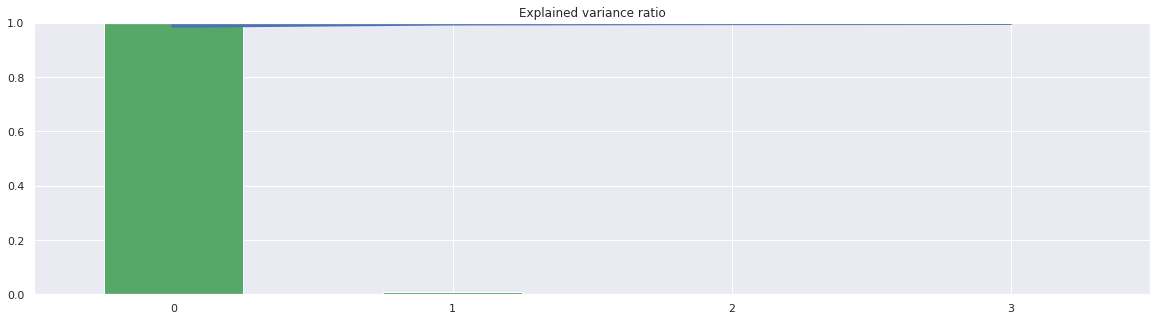

In [23]:
dfm.plot_explained_variance()

In [24]:
res = dfm.apply_residualizer(
    model_func=sklear.decomposition.PCA,
    x_vars=["CL1_ret_0", "CL2_ret_0", "CL3_ret_0", "CL4_ret_0"],
    model_kwargs={"n_components": 1},
    method="predict",
)

<AxesSubplot:>

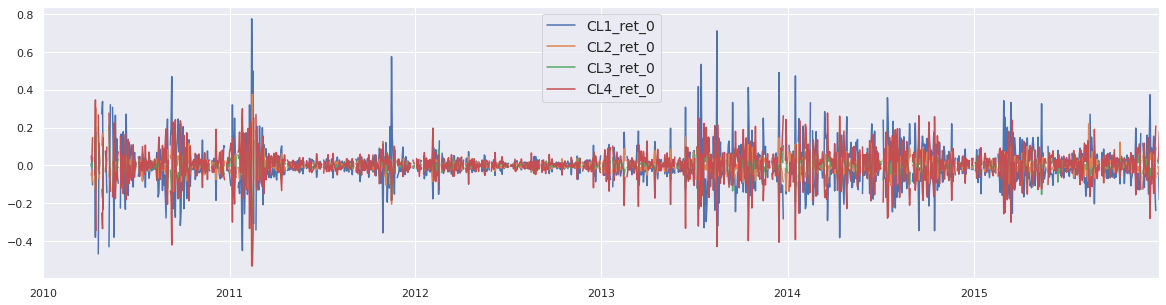

In [25]:
res.df.plot()